# CIFAR10 Image Classification using Keras 简洁版

In [12]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from utils import make_parallel, accuracy_curve
%matplotlib inline

nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 如果不进行归一化将会导致无法收敛
X_train /= 255
X_test /= 255

In [31]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Flatten()(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

model1 = Model(inputs=x, outputs=y, name='model1')

model1 = make_parallel(model1, 2)

model1.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [32]:
def train(model, batch, epoch, data_augmentation=True):
    start = time()
    es = EarlyStopping(monitor='val_acc', patience=20)
    mc = ModelCheckpoint('CIFAR10-EP{epoch:02d}-ACC{val_acc:.4f}.h5', monitor='val_acc', save_best_only=True)
    
    if data_augmentation:
        aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
        aug.fit(X_train)
        gen = aug.flow(X_train, y_train, batch_size=batch)
        h = model.fit_generator(generator=gen, 
                                 steps_per_epoch=50000/batch, 
                                 epochs=epoch, 
                                 validation_data=(X_test, y_test),
                                 callbacks=[es, mc])
    else:
        start = time()
        h = model.fit(x=X_train, 
                      y=y_train, 
                      batch_size=batch, 
                      epochs=epoch, 
                      validation_data=(X_test, y_test),
                      callbacks=[es, mc])
    
    print('\n@ Total Time Spent: %.2f seconds' % (time() - start))
    acc, val_acc = h.history['acc'], h.history['val_acc']
    m_acc, m_val_acc = np.argmax(acc), np.argmax(val_acc)
    print("@ Best Training Accuracy: %.2f %% achieved at EP #%d." % (acc[m_acc] * 100, m_acc + 1))
    print("@ Best Testing Accuracy: %.2f %% achieved at EP #%d." % (val_acc[m_val_acc] * 100, m_val_acc + 1))
    return h

Epoch 1/200
391/390 [==============================] - 12s - loss: 1.7750 - acc: 0.3557 - val_loss: 1.3944 - val_acc: 0.4851
Epoch 2/200
391/390 [==============================] - 12s - loss: 1.3431 - acc: 0.5164 - val_loss: 1.3958 - val_acc: 0.5237
Epoch 3/200
391/390 [==============================] - 11s - loss: 1.1166 - acc: 0.6062 - val_loss: 0.9615 - val_acc: 0.6608
Epoch 4/200
391/390 [==============================] - 11s - loss: 0.9571 - acc: 0.6634 - val_loss: 0.8545 - val_acc: 0.7014
Epoch 5/200
391/390 [==============================] - 12s - loss: 0.8542 - acc: 0.7021 - val_loss: 0.7359 - val_acc: 0.7473
Epoch 6/200
391/390 [==============================] - 12s - loss: 0.7813 - acc: 0.7279 - val_loss: 0.7963 - val_acc: 0.7267
Epoch 7/200
391/390 [==============================] - 12s - loss: 0.7180 - acc: 0.7498 - val_loss: 0.6218 - val_acc: 0.7886
Epoch 8/200
391/390 [==============================] - 11s - loss: 0.6687 - acc: 0.7670 - val_loss: 0.6973 - val_acc: 0.7675


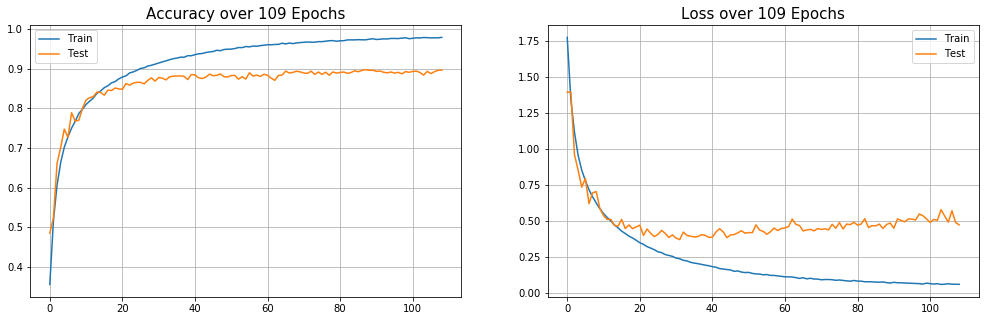

In [33]:
epoch = 200
batch = 128

h = train(model1, batch, epoch)
accuracy_curve(h)

In [34]:
def further_train(model, batch, epoch, data_augmentation=True):
    start = time()
    es = EarlyStopping(monitor='val_acc', patience=20)
    mc = ModelCheckpoint('CIFAR10-EP{epoch:02d}-ACC{val_acc:.4f}.h5', monitor='val_acc', save_best_only=True)
    
    if data_augmentation:
        aug = ImageDataGenerator(width_shift_range = 0.125, height_shift_range = 0.125, horizontal_flip = True)
        aug.fit(X_train)
        gen = aug.flow(X_train, y_train, batch_size=batch)
        h = model.fit_generator(generator=gen, 
                                 steps_per_epoch=50000/batch, 
                                 epochs=epoch, 
                                 validation_data=(X_test, y_test),
                                 callbacks=[es, mc])
    else:
        start = time()
        h = model.fit(x=X_train, 
                      y=y_train, 
                      batch_size=batch, 
                      epochs=epoch, 
                      validation_data=(X_test, y_test),
                      callbacks=[es, mc])
    
    print('\n@ Total Time Spent: %.2f seconds' % (time() - start))
    acc, val_acc = h.history['acc'], h.history['val_acc']
    m_acc, m_val_acc = np.argmax(acc), np.argmax(val_acc)
    print("@ Best Training Accuracy: %.2f %% achieved at EP #%d." % (acc[m_acc] * 100, m_acc + 1))
    print("@ Best Testing Accuracy: %.2f %% achieved at EP #%d." % (val_acc[m_val_acc] * 100, m_val_acc + 1))
    return h

Epoch 1/200
391/390 [==============================] - 12s - loss: 0.0837 - acc: 0.9720 - val_loss: 0.5059 - val_acc: 0.8916
Epoch 2/200
391/390 [==============================] - 11s - loss: 0.0816 - acc: 0.9721 - val_loss: 0.5131 - val_acc: 0.8911
Epoch 3/200
391/390 [==============================] - 11s - loss: 0.0806 - acc: 0.9733 - val_loss: 0.4740 - val_acc: 0.8957
Epoch 4/200
391/390 [==============================] - 11s - loss: 0.0741 - acc: 0.9750 - val_loss: 0.4790 - val_acc: 0.8935
Epoch 5/200
391/390 [==============================] - 11s - loss: 0.0771 - acc: 0.9733 - val_loss: 0.4968 - val_acc: 0.8953
Epoch 6/200
391/390 [==============================] - 11s - loss: 0.0777 - acc: 0.9737 - val_loss: 0.4784 - val_acc: 0.8934
Epoch 7/200
391/390 [==============================] - 11s - loss: 0.0785 - acc: 0.9736 - val_loss: 0.5152 - val_acc: 0.8933
Epoch 8/200
391/390 [==============================] - 11s - loss: 0.0757 - acc: 0.9741 - val_loss: 0.4857 - val_acc: 0.8933


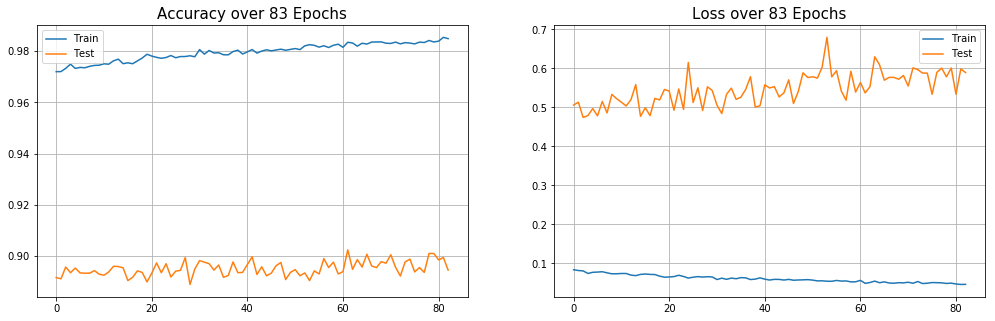

In [35]:
epoch = 200
batch = 128

h = further_train(model1, batch, epoch)
accuracy_curve(h)